# Transformer model

1. Synchronisation des données

Pour synchroniser les données, nous avons fait une interpolation entre les mesures de la main droite et la main gauche.

In [5]:
import pandas as pd

left = pd.read_csv('2ia-2024-hackathon/left_accs.csv')
right = pd.read_csv('2ia-2024-hackathon/right_accs.csv')

left = left.iloc[::2]
right = right.iloc[::2]

left.columns = ['timestamp', 'x_left', 'y_left', 'z_left']
right.columns = ['timestamp', 'x_right', 'y_right', 'z_right']

left['timestamp'] = pd.to_datetime(left['timestamp'], unit='s')
right['timestamp'] = pd.to_datetime(right['timestamp'], unit='s')

df = pd.merge_asof(left.sort_values('timestamp'), 
                       right.sort_values('timestamp'), 
                       on='timestamp', 
                       direction='nearest')

# Vérifier les valeurs manquantes dues à des timestamps non alignés
df.interpolate(method='linear', inplace=True)
df['timestamp'] = df['timestamp'].dt.round('10ms')

df.head()


,timestamp,x_left,y_left,z_left,x_right,y_right,z_right
0,2024-07-19 20:00:05.080,-224,-92,-60,-240,20,56
1,2024-07-19 20:00:05.120,-240,-96,-72,-240,20,56
2,2024-07-19 20:00:05.160,-248,-108,-80,-240,20,56
3,2024-07-19 20:00:05.200,-236,-100,-64,-240,20,56
4,2024-07-19 20:00:05.240,-244,-104,-68,-240,20,56


2. Downsampling

Notre fichier 'synchronized_data_with_classes' contient les deux bras synchronisés précédemment, ainsi que les classes retranscrites à partir du journal d'activité de la patiente.
Nous avons considéré qu'étant donné les mouvements de la personne (une personne d'âge moyen effectuant des mouvements quotidiens), il était possible d'avoir une granularité moins fine; nous avons moyenné les données par seconde.

In [11]:
classes = pd.read_csv('synchronized_data_with_classes.csv')
classes['timestamp'] = pd.to_datetime(classes['timestamp'], unit='s')
classes.set_index('timestamp', inplace=True)

classes_resampled = classes.resample('1s').agg({
    'Classe': lambda x: x.mode()[0] if not x.mode().empty else None,
    'x_left': 'mean',
    'y_left': 'mean',
    'z_left': 'mean',
    'x_right': 'mean',
    'y_right': 'mean',
    'z_right': 'mean'
})

classes_resampled.head()

/var/folders/b0/pjw720ys6bs9qzq0z497tbww0000gn/T/ipykernel_4645/2341169877.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  classes = pd.read_csv('synchronized_data_with_classes.csv')


,Classe,x_left,y_left,z_left,x_right,y_right,z_right
timestamp,,,,,,,
2024-07-19 20:00:07,none,-241.647059,-100.941176,-79.843137,-247.571429,23.285714,57.428571
2024-07-19 20:00:08,none,-245.200000,-86.320000,-76.240000,-252.880000,18.720000,43.040000
2024-07-19 20:00:09,none,-248.235294,-80.470588,-71.450980,-244.240000,16.240000,76.560000
2024-07-19 20:00:10,none,-250.480000,-89.280000,-25.840000,-238.000000,17.760000,92.000000
2024-07-19 20:00:11,none,-248.960000,-94.160000,-6.800000,-235.918367,23.591837,93.469388


A cause du manque de données (et de la sous-représentation de tf), nous avons dû, lors des phases de test, entraîner jusqu'au jour 4 et tester sur le jour 5. Ensuite, si les performances étaient acceptables, nous ré-entraînions le modèle sur tous les jours disponibles (les 6), et testions sur le jour 6 également.

In [120]:
classes_resampled.index = pd.to_datetime(classes_resampled.index)
classes_resampled['date'] = classes_resampled.index.date

features = ['x_left', 'y_left', 'z_left', 'x_right', 'y_right', 'z_right']

train_data = classes_resampled[classes_resampled['date'] < pd.Timestamp('2024-07-25').date()]
X_train = train_data[features]
y_train = train_data['Classe']

target_date = pd.Timestamp('2024-07-24').date()
test_data = classes_resampled[classes_resampled['date'] == target_date]
X_test = test_data[features]
y_test = test_data['Classe']

classes_resampled = classes_resampled.drop(columns=['date'])

train_data.tail()

,Classe,x_left,y_left,z_left,x_right,y_right,z_right,date
timestamp,,,,,,,,
2024-07-24 23:59:55,none,144.784314,-28.549020,184.078431,-159.755102,27.346939,192.571429,2024-07-24
2024-07-24 23:59:56,none,145.490196,-28.235294,184.000000,-159.836735,27.020408,192.489796,2024-07-24
2024-07-24 23:59:57,none,145.040000,-28.720000,184.080000,-159.673469,27.428571,192.489796,2024-07-24
2024-07-24 23:59:58,none,145.280000,-28.720000,184.000000,-159.836735,27.265306,192.979592,2024-07-24
2024-07-24 23:59:59,none,145.176471,-28.784314,184.078431,-159.680000,27.600000,192.720000,2024-07-24


In [121]:
y_train.head()

timestamp
2024-07-19 20:00:07    none
2024-07-19 20:00:08    none
2024-07-19 20:00:09    none
2024-07-19 20:00:10    none
2024-07-19 20:00:11    none
Freq: s, Name: Classe, dtype: object

In [122]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

sequence_length = 60

label_encoder = LabelEncoder()

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length]) 
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_seq, y_train_seq = create_sequences(X_train.to_numpy(), y_train_encoded, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test.to_numpy(), y_test_encoded, sequence_length)

# Vérification
print("Shape de X_train_seq:", X_train_seq.shape)
print("Shape de y_train_seq:", y_train_seq.shape)


Shape de X_train_seq: (446333, 60, 6)
Shape de y_train_seq: (446333,)


In [123]:
y_train.head()

array([0, 2, 4, 5, 6, 7])

3. Modèle et entrainement

Nous définissons le fbeta score sur lequel nous sommes évalués dans notre transformer afin qu'il soit optimisé par notre modèle.
Malehureusement, nous n'avons pas réussi à l'optimiser sur notre phase d'entrainement. Il n'a donc pas été utilisé.

In [ ]:
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import keras

def fbeta_score(y_true, y_pred, beta=1/3):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(y_pred, depth=tf.shape(y_pred)[-1])

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    tp = tf.reduce_sum(y_true * y_pred, axis=0)  # True positives
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)  # False positives
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)  # False negatives

    precision = tp / (tp + fp + keras.backend.epsilon())  # précision
    recall = tp / (tp + fn + keras.backend.epsilon())  # recall

    beta_squared = beta ** 2
    fbeta = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + keras.backend.epsilon())
    return tf.reduce_mean(fbeta)


model = Sequential([
    LSTM(128, input_shape=(sequence_length, len(features)), return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(len(y_train.unique()), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


/opt/anaconda3/envs/TP1_2IA_ML_ADVANCED/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 128)            │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,896 (304.28 KB)

 Trainable params: 77,896 (304.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=2,
    batch_size=32
)

Epoch 1/2
13948/13948 ━━━━━━━━━━━━━━━━━━━━ 250s 18ms/step - accuracy: 0.8673 - loss: 0.4476 - val_accuracy: 0.8815 - val_loss: 0.3502
Epoch 2/2
13948/13948 ━━━━━━━━━━━━━━━━━━━━ 246s 18ms/step - accuracy: 0.8865 - loss: 0.3410 - val_accuracy: 0.8962 - val_loss: 0.2874


In [137]:
y_pred_seq = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred_seq, axis=1)

y_pred_labels = label_encoder.inverse_transform(y_pred_classes)


2699/2699 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


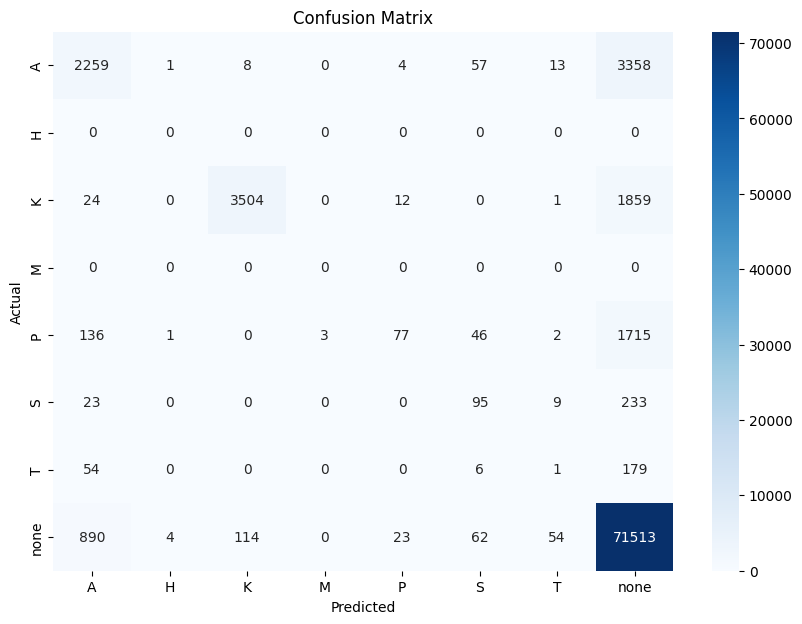

In [142]:
#confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_seq, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [145]:
target_date = pd.Timestamp('2024-07-25').date()
classes = pd.read_csv('synchronized_data_with_classes.csv')
classes['timestamp'] = pd.to_datetime(classes['timestamp'], unit='s')
classes.set_index('timestamp', inplace=True)

classes_resampled = classes.resample('1s').agg({
    'Classe': lambda x: x.mode()[0] if not x.mode().empty else None,
    'x_left': 'mean',
    'y_left': 'mean',
    'z_left': 'mean',
    'x_right': 'mean',
    'y_right': 'mean',
    'z_right': 'mean'
})

/var/folders/b0/pjw720ys6bs9qzq0z497tbww0000gn/T/ipykernel_4645/620267478.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  classes = pd.read_csv('synchronized_data_with_classes.csv')


In [165]:
classes_resampled.index = pd.to_datetime(classes_resampled.index)
classes_resampled['date'] = classes_resampled.index.date

test_data = classes_resampled[classes_resampled['date'] == target_date]

test_data = test_data.between_time('07:00:00', '19:00:01').drop(columns=['Classe', 'date'])

## Prédiction

x = create_sequences(test_data.to_numpy(), np.zeros(len(test_data)), 1)[0]

y = model.predict(x)
y_classes = np.argmax(y, axis=1)

y_labels = label_encoder.inverse_transform(y_classes)


1351/1351 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


In [168]:
time_series = pd.date_range(start='07:00:00', end='19:00:00', freq='s').strftime('%H:%M:%S')

if len(y_labels) != len(time_series):
    raise ValueError("Le nombre de prédictions ne correspond pas au nombre de pas de temps générés !")

# Étape 5 : Créer le DataFrame final
output_df = pd.DataFrame({
    'time': time_series,
    'activity': y_labels 
})

output_df.to_csv('predictions_25juillet2024_2.csv', index=False, quoting=1)


In [171]:
output_df['activity'].value_counts()

activity
none    42600
A         358
K         238
H           5
Name: count, dtype: int64

We also tried two other models, but they were not satisfying.

# Other models
## XGBOOST

In [117]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

df = pd.read_csv('synchronized_data_with_classes-H.csv', parse_dates=['timestamp'])

df['date'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.date

train_df = df[df['date'] <= pd.to_datetime('2024-07-23').date()] 
test_df = df[df['date'] == pd.to_datetime('2024-07-24').date()]

train_df['Classe'] = pd.Categorical(train_df['Classe']).codes
test_df['Classe'] = pd.Categorical(test_df['Classe']).codes

features = ['x_left', 'y_left', 'z_left', 'x_right', 'y_right', 'z_right']
X_train = train_df[features]
y_train = train_df['Classe']

X_test = test_df[features]
y_test = test_df['Classe']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

y_test = pd.Categorical(y_test).codes
y_pred = pd.Categorical(y_pred).codes

print("Classification Report :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


/var/folders/b0/pjw720ys6bs9qzq0z497tbww0000gn/T/ipykernel_4645/1597108378.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Classe'] = pd.Categorical(train_df['Classe']).codes
/var/folders/b0/pjw720ys6bs9qzq0z497tbww0000gn/T/ipykernel_4645/1597108378.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Classe'] = pd.Categorical(test_df['Classe']).codes
/opt/anaconda3/envs/TP1_2IA_ML_ADVANCED/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:07:41] WARNING: /Users/runn

Classification Report :
              precision    recall  f1-score   support

           0       0.26      0.06      0.10      5700
           1       0.00      0.00      0.00      5400
           2       0.04      0.00      0.00      1980
           3       0.00      0.00      0.00       360
           4       0.00      0.00      0.00       240
           5       0.44      0.00      0.00     72720
           6       0.00      0.00      0.00         0

    accuracy                           0.00     86400
   macro avg       0.11      0.01      0.01     86400
weighted avg       0.39      0.00      0.01     86400

Matrice de confusion :
[[  352     4     2     2    48     6  5286]
 [   29     0     8     2     0     2  5359]
 [   64     0     1     0     0     1  1914]
 [    8     0     0     0     0     0   352]
 [    2     0     0     0     0     0   238]
 [  874     1    12     3     8     7 71815]
 [    0     0     0     0     0     0     0]]


/opt/anaconda3/envs/TP1_2IA_ML_ADVANCED/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/TP1_2IA_ML_ADVANCED/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/TP1_2IA_ML_ADVANCED/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

## MLP

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv('synchronized_data_with_classes-H.csv')

df.columns = ['timestamp', 'x_left', 'y_left', 'z_left', 'x_right', 'y_right', 'z_right', 'Classe']

df['date'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.date  # Extraire la date sous format 'YYYY-MM-DD'

train_df = df[df['date'] <= pd.to_datetime('2024-07-23').date()]  
test_df = df[df['date'] == pd.to_datetime('2024-07-24').date()] 

test_df['Classe'] = test_df['Classe'].fillna('none')

train_df['Classe'] = pd.Categorical(train_df['Classe']).codes
test_df['Classe'] = pd.Categorical(test_df['Classe']).codes

features = ['x_left', 'y_left', 'z_left', 'x_right', 'y_right', 'z_right']
X_train = train_df[features]
y_train = train_df['Classe']
X_test = test_df[features]
y_test = test_df['Classe']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42, activation='relu')

mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)

print("Classification Report :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


/var/folders/b0/pjw720ys6bs9qzq0z497tbww0000gn/T/ipykernel_10996/2003711067.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Classe'] = test_df['Classe'].fillna('none')
/var/folders/b0/pjw720ys6bs9qzq0z497tbww0000gn/T/ipykernel_10996/2003711067.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Classe'] = pd.Categorical(train_df['Classe']).codes
/var/folders/b0/pjw720ys6bs9qzq0z497tbww0000gn/T/ipykernel_10996/2003711067.py:18: SettingWithCopyWarning: 
A value is trying to be set on 

Classification Report :
              precision    recall  f1-score   support

           0       0.30      0.15      0.20      5700
           1       0.07      0.00      0.00      5400
           2       0.00      0.00      0.00      1980
           3       0.07      0.00      0.01       360
           4       0.00      0.00      0.00       240
           5       0.58      0.00      0.00     72720
           6       0.00      0.00      0.00         0

    accuracy                           0.01     86400
   macro avg       0.14      0.02      0.03     86400
weighted avg       0.51      0.01      0.01     86400

Matrice de confusion :
[[  834     2     0     4    17     7  4836]
 [  107     1     0     4    12     2  5274]
 [  194     1     0     0     8     5  1772]
 [   24     0     0     1     1     0   334]
 [   13     0     0     0     0     2   225]
 [ 1628    11     2     6    41    22 71010]
 [    0     0     0     0     0     0     0]]


/opt/anaconda3/envs/TP1_2IA_ML_ADVANCED/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/TP1_2IA_ML_ADVANCED/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/TP1_2IA_ML_ADVANCED/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",